In [37]:
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('ggplot')
experiment_dir = '../VGG_38' #Replace this with your path to the mlpractical directory
if os.path.exists(experiment_dir):
    print(f"The directory '{experiment_dir}' exists.")
else:
    print(f"The directory '{experiment_dir}' does NOT exist. Check your path.")
print(os.getcwd())

The directory '../VGG_38' exists.
/home/natmaw/Documents/ML_Practical/mlpractical_natmaws/notebooks


In [38]:
def collect_experiment_dicts(target_dir, test_flag=False):
    experiment_dicts = dict()
    for subdir, dir, files in os.walk(target_dir):
        for file in files:
            filepath = None
            if not test_flag:
                if file == 'summary.csv':
                    filepath = os.path.join(subdir, file)
            
            elif test_flag:
                if file == 'test_summary.csv':
                    filepath = os.path.join(subdir, file)
            
            if filepath is not None:
                
                with open(filepath, 'r') as read_file:
                    lines = read_file.readlines()
                    
                current_experiment_dict = {key: [] for key in lines[0].replace('\n', '').split(',')}
                idx_to_key = {idx: key for idx, key in enumerate(lines[0].replace('\n', '').split(','))}
                
                for line in lines[1:]:
                    for idx, value in enumerate(line.replace('\n', '').split(',')):
                        current_experiment_dict[idx_to_key[idx]].append(float(value))
                
                experiment_dicts[subdir.split('/')[-2]] = current_experiment_dict
                
    return experiment_dicts
                
            

In [39]:
result_dict = collect_experiment_dicts(target_dir=experiment_dir)
for key, value in result_dict.items():
    print(key, list(value.keys()))

VGG_38 ['train_acc', 'train_loss', 'val_acc', 'val_loss']


In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def plot_result_graphs(plot_name, stats, keys_to_plot, notebook=True):
    
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for name in keys_to_plot:
        for k in ['train_loss', 'val_loss']:
            item = stats[name][k]
            ax_1.plot(np.arange(0, len(item)), 
                      item, label='{}_{}'.format(name, k))
            
    ax_1.legend(loc=0)
    ax_1.set_ylabel('Loss')
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for name in keys_to_plot:
        for k in ['train_acc', 'val_acc']:
            item = stats[name][k]
            ax_2.plot(np.arange(0, len(item)), 
                      item, label='{}_{}'.format(name, k))
            
    ax_2.legend(loc=0)
    ax_2.set_ylabel('Accuracy')
    ax_2.set_xlabel('Epoch number')
    
    fig_1.savefig('../data/{}_loss_performance.pdf'.format(plot_name), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
    
    fig_2.savefig('../data/{}_accuracy_performance.pdf'.format(plot_name), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
    


TypeError: FigureCanvasPdf.print_pdf() got an unexpected keyword argument 'papertype'

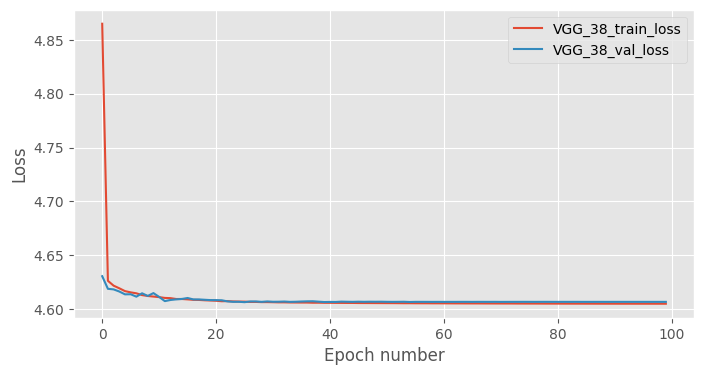

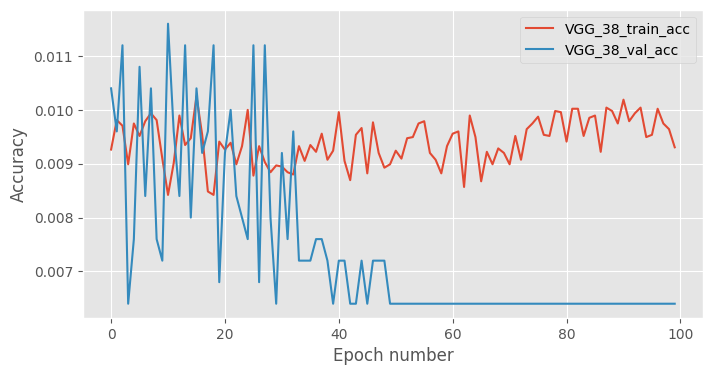

In [41]:
plot_result_graphs('problem_model', result_dict, keys_to_plot=['VGG_38'])#, 'VGG_08'])

In [42]:
import json  # Add import for saving gradient flow data

def plot_grad_flow(self, named_parameters, epoch_idx):
    all_grads = []
    layers = []

    for name, params in named_parameters:
        if params.requires_grad and 'batch_norm' not in name and 'bias' not in name:
            all_grads.append(params.grad.cpu().abs().mean().item())
            layer_name = name.replace('layer_dict.', '_').replace('.', '').replace('weight', '')
            if layer_name.startswith('_'):
                layer_name = layer_name[1:]
            layers.append(layer_name)

    # Save gradient flow data as JSON for this epoch
    grad_flow_dir = os.path.join(self.experiment_saved_models, 'gradient_flow_data')
    if not os.path.exists(grad_flow_dir):
        os.makedirs(grad_flow_dir)
    grad_flow_path = os.path.join(grad_flow_dir, f'epoch_{epoch_idx}.json')
    with open(grad_flow_path, 'w') as f:
        json.dump({'layers': layers, 'grads': all_grads}, f)
        
    # Generate and return the plot
    plt = self.plot_func_def(all_grads, layers)
    return plt

def collect_gradient_data(grad_flow_dir):
    gradient_data = {}
    for file in os.listdir(grad_flow_dir):
        if file.endswith('.json'):
            epoch = int(file.split('_')[1].split('.')[0])
            with open(os.path.join(grad_flow_dir, file), 'r') as f:
                data = json.load(f)
            gradient_data[epoch] = data
    return gradient_data

def plot_gradient_flow_over_epochs(gradient_data):
    for epoch, data in sorted(gradient_data.items()):
        plt.figure(figsize=(10, 6))
        plt.plot(data['grads'], alpha=0.3, color="b")
        plt.hlines(0, 0, len(data['grads']), linewidth=1, color="k")
        plt.xticks(range(len(data['grads'])), data['layers'], rotation="vertical")
        plt.xlim(xmin=0, xmax=len(data['grads']))
        plt.xlabel("Layers")
        plt.ylabel("Average Gradient")
        plt.title(f"Gradient Flow at Epoch {epoch}")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'../data/gradient_flow_epoch_{epoch}.pdf')
        plt.close()
        
gradient_flow_dir = os.path.join(experiment_dir, 'saved_models', 'gradient_flow_data')
if os.path.exists(gradient_flow_dir):
    gradient_data = collect_gradient_data(gradient_flow_dir)
    plot_gradient_flow_over_epochs(gradient_data)
else:
    print(f"No gradient flow data found in {gradient_flow_dir}")

No gradient flow data found in ../VGG_38/saved_models/gradient_flow_data
